<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Подготовка данных

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier


import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Импорт выглядит отлично 👍
</div>

In [17]:
df = pd.read_csv('/datasets/Churn.csv')



In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [19]:
# Переведем названия в нижний регистр
df.columns = df.columns.str.lower()

In [22]:
df.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


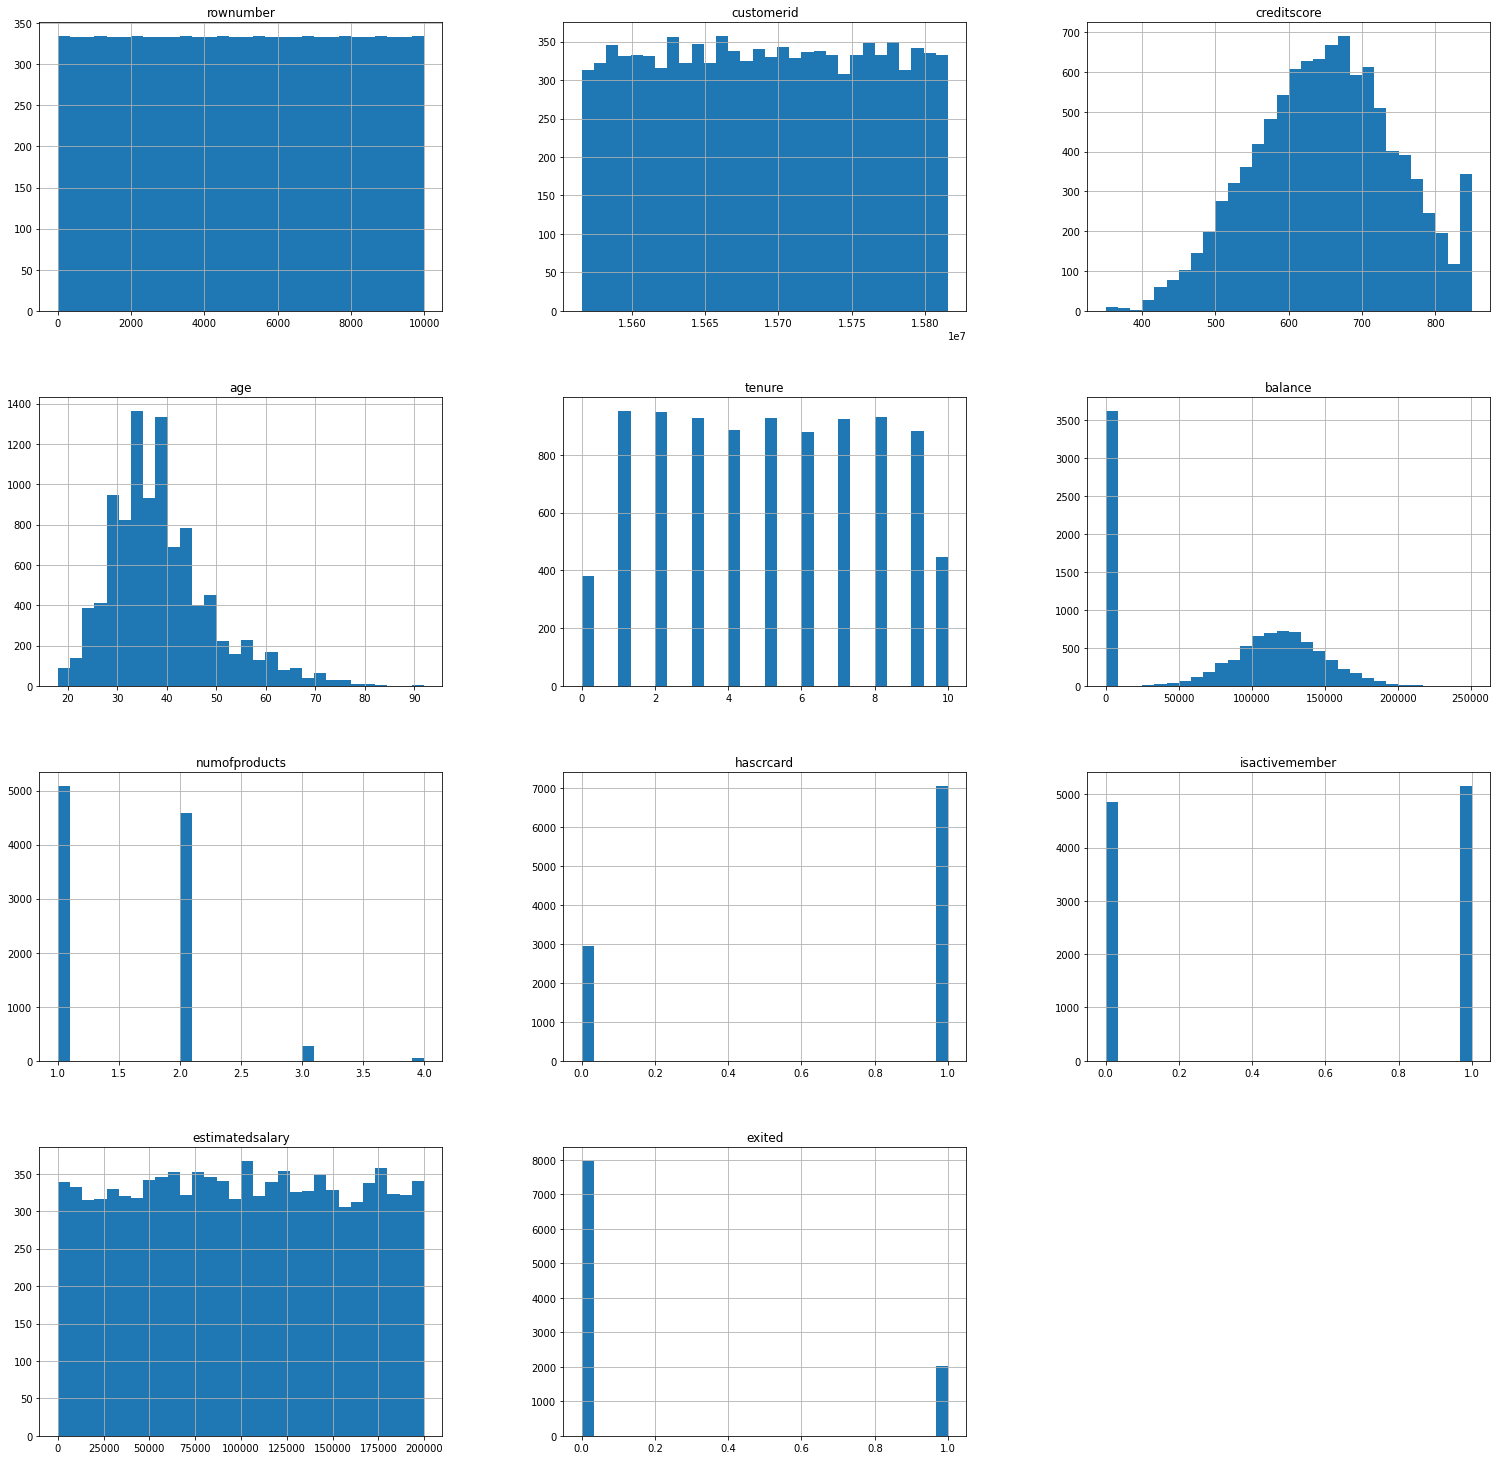

In [5]:
df.hist(figsize=(26,26), bins=30)
plt.show()

In [29]:
#Проверим на дубликаты
df.duplicated().sum()

0

In [30]:
df['tenure'] = df['tenure'].fillna(0)

В одном столбе tenure есть пропуски.
Я предпринял решение удалить объекты с пропущенными значениями, так как количество не велико(около 10%), что не появлиеят на ход моего проекта.

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>
    
Согласен с таким заполнением 👍
</div>

# Вывод

RowNumber — столбец дублирует информацию стандартного датафрейма и не несетя ценности для обучения модели, поэтому столбец можно удалить
CustomerId — является идентификатором пользователя, стоблец также можно удалить.
Surname — является идентифицирующей пользователя информацией, не несет ценности для качества будущей модели — столбец можно удалить.
Geography — всего 3 уникальных значения France', 'Spain', 'Germany' — выполнить преобразование OHE / ordinal encoding
Gender — значение преобразовать — OHE

## Исследование задачи

Подготовка данных для ML

In [21]:
#Обозначим новый датафрейм "df_ml" — данные для ml
#Удалим столбцы-идентификаторы, не представляющие ценностия для алгоритма 
df_ml = df.drop(['rownumber','customerid', 'surname'], axis=1)
df_ml.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Удалить неинформативные признаки - хорошее решение 👍
</div>

In [86]:
df_ml.shape

(10000, 11)

# Создам выборки
Обучающая - 60%, Валидационная - 20%, тестовая - 20%

In [32]:
#Разделим на признаки и целевой признак
features = df_ml.drop('exited', axis=1)
target = df_ml['exited']

In [33]:
#Тренеровочная 60%
features_train, features_validtest, target_train, target_validtest = train_test_split(
    features, target, train_size=0.6, random_state=12345)

In [34]:
#Валид и тест соответственно поровну по 20% от общей
features_valid, features_test, target_valid, target_test = train_test_split(
    features_validtest, target_validtest, train_size=0.5, random_state=12345)

In [35]:
#Данные перекодирую методом OHE, что позволит мне использовать разные модели и не попасть дамми ловушку
features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> 

Данные поделены верно, пропорции выбраны адекватные 👍
</div>

# Вывод:
- Были созданны выборки:
- Обучающая features_train target_train,
- Валидационная features_valid target_valid,
- Тестовая features_test target_test

In [37]:
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
7479,567,35,8.0,153137.74,1,1,0,88659.07,0,1,1
3411,711,37,8.0,113899.92,1,0,0,80215.20,0,0,0
6027,850,44,3.0,140393.65,2,0,1,186285.52,1,0,1
1247,512,24,6.0,0.00,2,1,0,37654.31,0,0,1
3716,665,27,2.0,147435.96,1,0,0,187508.06,1,0,0


In [38]:
#Для масштабирования методом scaler зафиксируем численные признаки
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

In [39]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [40]:
#Масштабируем числовые признаки обучающей выборки
features_train[numeric] = scaler.transform(features_train[numeric])

In [41]:
#Масштабируем численные признаки валидационной выборки 
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [42]:
#Масштабируем численные признаки тестовой выборки 
features_test[numeric] = scaler.transform(features_test[numeric])

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Отлично, признаки масштабированы 👍 Не забыли, что fit нужно делать только на train выборке.
</div>

# Применение модели машинного обучения
В результате мы имеем масштабированные признаки для трех выборок, начну  обучение моделей.

In [43]:
def all_models_accuracy(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(random_state=1515)
    DTC_score = model_DTC.fit(features_train, target_train).score(features_valid, target_valid)
    
    model_RFC = RandomForestClassifier(max_depth=7, n_estimators=43, min_samples_leaf=3, random_state=1515)
    RFC_score = model_RFC.fit(features_train, target_train).score(features_valid, target_valid)
    
    model_LgR = LogisticRegression(solver = 'liblinear')
    LgR_score = model_LgR.fit(features_train, target_train).score(features_valid, target_valid)
    print("Точность:" "дерево решений", DTC_score, "случайный лес ", RFC_score, "логистческая регрессия", LgR_score)

In [44]:
all_models_accuracy(features_train, target_train, features_valid, target_valid)

Точность:дерево решений 0.788 случайный лес  0.857 логистческая регрессия 0.8025


In [45]:
target_train.value_counts(normalize = 1)

0    0.800667
1    0.199333
Name: exited, dtype: float64

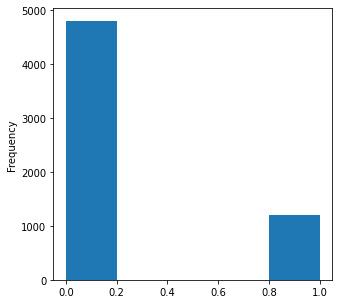

In [46]:
# Построим диаграмму баланса классов
target_train.plot(kind ='hist', bins=5, figsize=(5,5));

Как я выяснил в нашей выборке отрицательны ответов приблизительно 80% , положитительных приблизительно 20%. Я наблюдаю  дисбаланс.

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Виден явный дисбаланс классов в пользу отрицательного класса. Если мы будем всех людей прогнозировать, что они не уйдут из банка, то в 80% случаев мы будем правы.
</div>

In [47]:
#Заранее напишем функцию для изучия полноты, точности и F1-меры
def rec_prec_f1(target_valid, prediction):
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))

In [48]:
# Функция для отображения соотношения ответов моделей
def all_models_share(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(random_state=1010)
    model_DTC.fit(features_train, target_train)
    DTC_share = pd.Series(model_DTC.predict(features_valid)).value_counts(normalize = 1)
    
    
    
    model_RFC = RandomForestClassifier(random_state=1010, n_estimators = 100)
    model_RFC.fit(features_train, target_train)
    RFC_share = pd.Series(model_RFC.predict(features_valid)).value_counts(normalize = 1)
    
    model_LgR = LogisticRegression(solver = 'liblinear')
    model_LgR.fit(features_train, target_train)
    LgR_share = pd.Series(model_LgR.predict(features_valid)).value_counts(normalize = 1)
    

    
    print("Доли ответов:" "Дерево решений", DTC_share, "Случайный лес ", RFC_share, "Логистческая регрессия", LgR_share , end='')

In [49]:
#Применим функцию отображения соотношения ответов моделей
all_models_share(features_train, target_train, features_valid, target_valid)

Доли ответов:Дерево решений 0    0.7925
1    0.2075
dtype: float64 Случайный лес  0    0.8725
1    0.1275
dtype: float64 Логистческая регрессия 0    0.9125
1    0.0875
dtype: float64

Логистичесая регрессия показывала самую высокую точность, далее случайный лес и в конце дерево решений

построю матрицы ошибок для моделей

# Лес решений

In [50]:
model_RFC = RandomForestClassifier(random_state=1010, n_estimators = 100)
model_RFC.fit(features_train, target_train)
RFC_prediction = model_RFC.predict(features_valid)
confusion_matrix(target_valid, RFC_prediction)

array([[1521,   61],
       [ 224,  194]])

In [51]:
rec_prec_f1(target_valid, RFC_prediction)

Полнота 0.46411483253588515
Точность 0.7607843137254902
F1-мера 0.5765230312035662


In [52]:
#Расчет roc_auc_RFC
RFC_probabilities_one_valid = model_RFC.predict_proba(features_valid)[:, 1]
auc_roc_RFC = roc_auc_score(target_valid, RFC_probabilities_one_valid)
auc_roc_RFC

0.8458419782360165

Вывод лес решений примерно равную пропорцию позитивных и негативных предсказаний, выдает заметно больше качественных предсказаний, но также сильно склоняется к ложно позитивным предсказаниям (FP). Точность и качество также низкое.

# Дерево решений

In [53]:
#Матрица ошибок для дерево решений
model_DTC = DecisionTreeClassifier(random_state=1515)
model_DTC.fit(features_train, target_train)
DTC_prediction = model_DTC.predict(features_valid)
confusion_matrix(target_valid, DTC_prediction)

array([[1380,  202],
       [ 222,  196]])

Вывод Матрица показала, что дерево решений склонно выдавать позитивные предсказания, очень высокое количество ложных позитивных предсказания (FP)

In [54]:
rec_prec_f1(target_valid, DTC_prediction)

Полнота 0.4688995215311005
Точность 0.49246231155778897
F1-мера 0.4803921568627451


In [55]:
#Расчет roc_auc_DTC
DTC_probabilities_one_valid = model_DTC.predict_proba(features_valid)[:, 1]

auc_roc_DTC = roc_auc_score(target_valid, DTC_probabilities_one_valid)

auc_roc_DTC

0.6706065243559421

Вывод Видим низкое значение F1, следовательно низкое качество модели, проблема в точности.

# Логистическая регрессия

In [57]:
#Матрица ошибок для логистической регрессии
model_LgR = LogisticRegression(solver = 'liblinear')
model_LgR.fit(features_train, target_train)
LgR_prediction = model_LgR.predict(features_valid)
confusion_matrix(target_valid, LgR_prediction)

array([[1506,   76],
       [ 319,   99]])

In [58]:
rec_prec_f1(target_valid, LgR_prediction)

Полнота 0.23684210526315788
Точность 0.5657142857142857
F1-мера 0.33389544688026984


In [59]:
#Для логистической регрессии расчитаю метрику AUC-ROC
LgR_probabilities_one_valid = model_LgR.predict_proba(features_valid)[:, 1]

auc_roc_LgR = roc_auc_score(target_valid, LgR_probabilities_one_valid)

auc_roc_LgR

0.7586317967081824

In [60]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('ложно-положительный показатель')
    plt.ylabel('Истинно-положительный показатель')
    plt.title('ROC-кривая')
    plt.legend()
    plt.show()

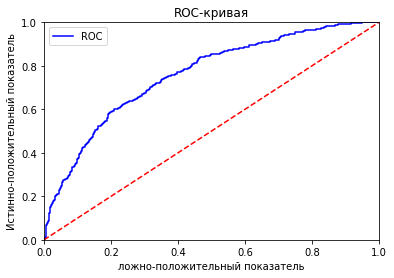

In [61]:
fper, tper, thresholds = roc_curve(target_valid, LgR_probabilities_one_valid)
plot_roc_curve(fper, tper)

Score 0.701
AUC-ROC 0.7635798063138539


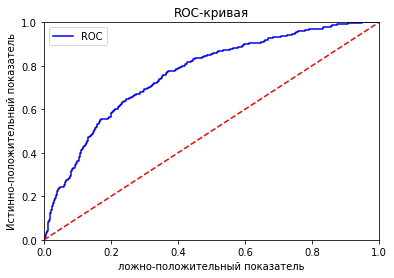

In [62]:
#Попробуем обучить логистическую регресию сбалансировав классы
model_LgR = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model_LgR.fit(features_train, target_train)
LgR_probabilities_one_valid_class_weight = model_LgR.predict_proba(features_valid)[:, 1]
print("Score", model_LgR.score(features_valid, target_valid))
print("AUC-ROC", roc_auc_score(target_valid, LgR_probabilities_one_valid_class_weight))

fper, tper, thresholds = roc_curve(target_valid, LgR_probabilities_one_valid_class_weight) 
plot_roc_curve(fper, tper)

Вывод нет заметных улучшений. Высокая точность модели объясняется высокой долей негативных ответов в валидационной выборке.



<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Модели обучены корректно 👍
</div>

## Борьба с дисбалансом

Как мы выяснили ранее в нашей выборке отрицательны ответов ≈80% , положитительных ≈ 20%. Нам необходмо увеличить количество положительных ответов в 4 раза для достижения баланса, либо уменьшить.

Разделим обучающую выборку на отрицательные и положительные объекты;
Скопируем несколько раз положительные объекты;
С учётом полученных данных создам новую обучающую выборку;
Перемешаю данные идущие друг за другом, одинаковые вопросы не помогут обучению.
Обучу новые модели

In [63]:
#Создам функцию для увеличения представленной класса в выборке 
def upsample(features, target, repeat, upsampled_сlass):
    """Функция принимаем значение признаков (features[]), целевого признака (target[]), repeat(int / float),
    класс который будет увеличен (upsampled_сlass (0 or 1))"""
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if upsampled_сlass == 0:
        features_upsampled = pd.concat([features_zeros]* repeat + [features_ones] )
        target_upsampled = pd.concat([target_zeros]* repeat + [target_ones] )
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
        
    elif upsampled_сlass == 1:
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    else:
        features_upsampled = 0
        target_upsampled = 0  
        
        
       
    return features_upsampled, target_upsampled

In [64]:
#Создам функцию для уменьшения представленной класса в выборке 
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [65]:
features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, fraction=0.25)

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Уменьшение выборки выполнено верно - классы сбалансированы 👍 
</div>

In [66]:
#Протестирую функцию (верное значение)
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 0)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

0    0.941407
1    0.058593
Name: exited, dtype: float64
(20412,)


In [67]:
#Протестирую функцию (верное значение)
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 3)
features_train_upsampled

0

In [68]:
#Применил функцию upsample 
#увеличил количество положительных ответов в 4 раза
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 1)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

0    0.501043
1    0.498957
Name: exited, dtype: float64
(9588,)


<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Увеличение выборки тоже выполнено верно 👍 
</div>

In [69]:
#Применил функцию downsample
#Уменьшил кол-в пооложительных ответов в 4 раза
#Протестируем функцию (верное значение)
features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, 0.2)
print(target_downsampled_train.value_counts(normalize = 0))
print(target_downsampled_train.shape)

1    1196
0     961
Name: exited, dtype: int64
(2157,)


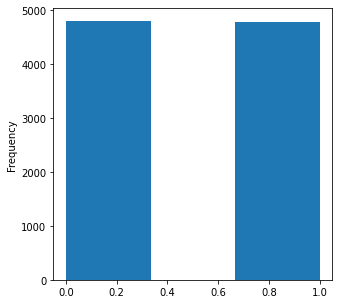

In [70]:
#upsample показал лучший результат с ним и буду работать
target_train_upsampled.plot(kind ='hist', bins=3, figsize=(5,5));

# Обучение моделей на сбалансированной выборке

In [71]:
#Точность моделей на выборке с дисбалансом
all_models_accuracy(features_train, target_train, features_valid, target_valid)

Точность:дерево решений 0.788 случайный лес  0.857 логистческая регрессия 0.8025


In [72]:
#Точность моделей на сбалансированной выборке
all_models_accuracy(features_train_upsampled, target_train_upsampled, features_valid, target_valid)

Точность:дерево решений 0.7805 случайный лес  0.813 логистческая регрессия 0.701


Вывод Точность сильно не изменилась. Проверим качество ответов.

In [73]:
#Дерево решений
model_DTC_upsampled = DecisionTreeClassifier(random_state=1515)
model_DTC_upsampled.fit(features_train_upsampled, target_train_upsampled)
DTC_prediction_upsampled = model_DTC_upsampled.predict(features_valid)
rec_prec_f1(target_valid, DTC_prediction_upsampled)

Полнота 0.45454545454545453
Точность 0.47381546134663344
F1-мера 0.46398046398046394


In [74]:
#Расчитаю auc_roc для DTC на сбалансированной выборке
DTC_upsampled_valid = model_DTC_upsampled.predict_proba(features_valid)[:, 1]

auc_roc_DTC = roc_auc_score(target_valid, DTC_upsampled_valid)

auc_roc_DTC

0.6605849902310079

In [75]:
#Лес решений
model_RFC_upsampled = RandomForestClassifier(max_depth=7, n_estimators=43, min_samples_leaf=3, random_state=1515)
model_RFC_upsampled.fit(features_train_upsampled, target_train_upsampled)
RFC_prediction_upsampled = model_RFC_upsampled.predict(features_valid)
rec_prec_f1(target_valid, RFC_prediction_upsampled)

Полнота 0.722488038277512
Точность 0.5392857142857143
F1-мера 0.6175869120654396


In [76]:
#Расчитаю auc_roc для RFC на сбалансированной выборке
RFC_upsampled_valid = model_RFC_upsampled.predict_proba(features_valid)[:, 1]
auc_roc_RFC = roc_auc_score(target_valid, RFC_upsampled_valid)
auc_roc_RFC

0.8527604207622839

In [77]:
#Логистическая регрессия
model_LgR_upsampled = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model_LgR_upsampled.fit(features_train_upsampled, target_train_upsampled)
LgR_prediction_upsampled = model_LgR_upsampled.predict(features_valid)
rec_prec_f1(target_valid, LgR_prediction_upsampled)

Полнота 0.6842105263157895
Точность 0.3803191489361702
F1-мера 0.4888888888888888


In [78]:
#Расчитаю auc_roc для LgR на сбалансированной выборке
LgR_upsampled_valid = model_LgR_upsampled.predict_proba(features_valid)[:, 1]

auc_roc_LgR = roc_auc_score(target_valid, LgR_upsampled_valid)

auc_roc_LgR

0.7634815115020053

Вывод


Лучший результаты показывает алгоритм лес решений (RandomForestClassifier). На валидационной выборке RandomForestClassifier уже показывает резульаты F1 меры = 0.61, что выше  целевого значения.

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

По модельной части замечаний нет!) Все этапы выполнены отлично 👍
</div>

## Тестирование модели

In [79]:
#Обучим финальную модель
model_RFC_final = RandomForestClassifier(
    bootstrap = True, class_weight = 'balanced', max_depth= 7,  n_estimators = 100, random_state=54321)
model_RFC_final.fit(features_train_upsampled, target_train_upsampled)

RandomForestClassifier(class_weight='balanced', max_depth=7, random_state=54321)

In [80]:
model_RFC_final_prediction = model_RFC_final.predict(features_test)
rec_prec_f1(target_test, model_RFC_final_prediction)

Полнота 0.7092198581560284
Точность 0.5263157894736842
F1-мера 0.6042296072507553


In [81]:
#Расчитаем auc_roc для RFC на тестовой выборке
model_RFC_final_valid = model_RFC_final.predict_proba(features_test)[:, 1]

auc_roc_RFC = roc_auc_score(target_test, model_RFC_final_valid)

auc_roc_RFC

0.8547246095243235

In [82]:
#Создаем константную модель
target_predict_constant = pd.Series([0]*len(target_test))
target_predict_constant.value_counts()

0    2000
dtype: int64

In [83]:
#Сравню показатель точности (accuracy_score) константной модели и финальной
print('accuracy_score константой модели:', accuracy_score(target_valid, target_predict_constant))
print('accuracy_score финальной модели:', accuracy_score(target_test, model_RFC_final_prediction))
#Дополнительно сравним AUC-ROC — единственный параметр подающийся сравнению, потому что константная подель содержит только негативные ответы
print('AUC-ROC константой модели:', roc_auc_score(target_valid, target_predict_constant))
print('AUC-ROC финальной модели:', roc_auc_score(target_test, model_RFC_final_valid))

accuracy_score константой модели: 0.791
accuracy_score финальной модели: 0.8035
AUC-ROC константой модели: 0.5
AUC-ROC финальной модели: 0.8547246095243235


Финальная модель показывает результаты лучше, чем константная модель — модель можно считать адекватной.

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Отличный результат 👍 
</div>

# Выводы
В первоначальные данных наблюдался значительный дисбаланс (80% ответов целевого признака были негативными и только 20% позитивными), из-за чего обученная на этих данных модель не проходила проверку на адекватность. Все модели не первоначальных данных характеризовались высокой степенью ошибок и низким качеством  величины (F1) — модели показывали низкие результаты точности и полноты.

Я устранил дисбаланс классов в обучающей выборки методом upsampling — увеличил количество значений позитивного класса в 4 раза. Так я достигл баланса классов в обучеющей выборке

Разобрал несколько вариантов борьбы с дисбалансом upsampling и downsampling

На новых данных все модели показали результат выше, чем на несбалансированной выборке. Лучшие показатели были у модели леса решений.

Финальная модель прошла проверку на адекватность в сравнении с контантной моделью:

accuracy_score константой модели: 0.791
accuracy_score финальной модели: 0.8035
AUC-ROC константой модели: 0.5
AUC-ROC финальной модели: 0.8547246095243235

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Вывод соответствует исследованию 👍
</div>

# <font color='orange'>Общее впечатление</font>
* Этот проект выполнен очень хорошо
* Видно, что приложено много усилий
* Молодец, что структурируешь ноутбук, приятно проверять такие работы
* У тебя чистый и лаконичный код
* Мне было интересно читать твои промежуточные выводы
* Твой уровень подачи материала находится на высоком уровне
* Молодец, отличная работа!
* Надеюсь, ревью было полезным
* Удачи в дальнейшем обучении 👋
